#Import Libraries

##Neptune Ai

In [1]:
! pip install neptune-client==0.4.132


In [2]:
pip install  neptune-contrib neptune-client


In [3]:
import neptune
from neptunecontrib.monitoring.keras import NeptuneMonitor
neptune.init(project_qualified_name='jathurshan0330/DataStorm2-round1', # change this to your `workspace_name/project_name`
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZmJkZjYxNGYtMTA0ZC00ZTc1LWJiMTYtNzczNjgwZWQ3OTUzIn0=', # change this to your api token
            )

Project(jathurshan0330/DataStorm2-round1)

##other necessary libraries

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy import stats 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Input,LSTM,Reshape,Conv2D,Flatten,Dropout,BatchNormalization, LeakyReLU, concatenate, GRU, GlobalMaxPooling1D, GlobalMaxPooling2D, Bidirectional

In [5]:
!pip install scikit-plot

#Read Data

##Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd '/content/drive/My Drive/Datastorm2.0'

/content/drive/My Drive/Datastorm2.0


In [8]:
!ls '/content/drive/My Drive/Datastorm2.0'

DataStorm2.0_Q1-v2.pdf			     train_data_upsamp_3.csv
Hotel-A-data-dictionary.csv		     train_data_upsamp_4.csv
Hotel-A-test.csv			     train_data_upsamp.csv
Hotel-A-train.csv			     train_labels_upsamp_2.csv
Hotel-A-validation.csv			     train_labels_upsamp_3.csv
submission_KNN_upsampled_0.33_0.33_0.33.csv  train_labels_upsamp_4.csv
train_data_upsamp_2.csv			     train_labels_upsamp.csv


##Data

In [9]:
train_data = pd.read_csv('Hotel-A-train.csv')
print(train_data.head()) 
print(train_data.shape)
val_data = pd.read_csv('Hotel-A-validation.csv')
print(val_data.head()) 
print(val_data.shape)
test_data = pd.read_csv('Hotel-A-test.csv')
print(test_data.head())
print(test_data.shape) 



   Reservation-id Gender  Age  ... Use_Promotion Discount_Rate Room_Rate
0        39428300      F   40  ...           Yes            10       218
1        77491756      F   49  ...            No             0       185
2        73747291      F   42  ...            No             0       119
3        67301739      M   25  ...           Yes             5       144
4        77222321      F   62  ...           Yes            10       242

[5 rows x 24 columns]
(27499, 24)
   Reservation-id Gender  Age  ... Use_Promotion Discount_Rate Room_Rate
0        45716350      M   56  ...           Yes            15       192
1        88857401      M   60  ...            No             0       187
2        16074440      F   58  ...           Yes            10       227
3        10992124      F   23  ...           Yes            25       189
4        15934351      F   47  ...           Yes            10       218

[5 rows x 24 columns]
(2749, 24)
   Reservation-id Gender  Age  ... Use_Promotion Discou

In [10]:
print(train_data.isna().sum())
print(val_data.isna().sum())
print(test_data.isna().sum())

Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults                    0
Children                  0
Babies                    0
Meal_Type                 0
Visted_Previously         0
Previous_Cancellations    0
Deposit_type              0
Booking_channel           0
Required_Car_Parking      0
Reservation_Status        0
Use_Promotion             0
Discount_Rate             0
Room_Rate                 0
dtype: int64
Reservation-id            0
Gender                    0
Age                       0
Ethnicity                 0
Educational_Level         0
Income                    0
Country_region            0
Hotel_Type                0
Expected_checkin          0
Expected_checkout         0
Booking_date              0
Adults 

In [11]:
train_labels = train_data.pop("Reservation_Status")
print(train_labels.head())

for i in range (len(train_labels)):
  if train_labels[i] == 'Check-In':
    train_labels[i] = 1
  if train_labels[i] == 'Canceled':
    train_labels[i] = 2
  if train_labels[i] == 'No-Show':
    train_labels[i] = 3

print(train_labels.head()) 

val_labels = val_data.pop("Reservation_Status")
print(val_labels.head())

for i in range (len(val_labels)):
  if val_labels[i] == 'Check-In':
    val_labels[i] = 1
   
  if val_labels[i] == 'Canceled':
    val_labels[i] = 2
  if val_labels[i] == 'No-Show':
    val_labels[i] = 3

print(val_labels.head()) 

0    Check-In
1    Check-In
2    Check-In
3    Check-In
4    Check-In
Name: Reservation_Status, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: Reservation_Status, dtype: object
0     No-Show
1    Canceled
2    Canceled
3    Check-In
4    Check-In
Name: Reservation_Status, dtype: object
0    3
1    2
2    2
3    1
4    1
Name: Reservation_Status, dtype: object


In [12]:
print("No of Check-In in training data : " +str((train_labels == 1).sum()))
print("No of Canceled in training data : " +str((train_labels == 2).sum()))
print("No of No-Show in training data : " +str((train_labels == 3).sum()))
tot=(train_labels == 1).sum()+(train_labels == 2).sum()+(train_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in training data = " +str((train_labels == 1).sum()/tot)+' : '+str((train_labels == 2).sum()/tot)+' : '+str((train_labels == 3).sum()/tot))


print("No of Check-In in validation data : " +str((val_labels == 1).sum()))
print("No of Canceled in validation data : " +str((val_labels == 2).sum()))
print("No of No-Show in validation data : " +str((val_labels == 3).sum()))
tot=(val_labels == 1).sum()+(val_labels == 2).sum()+(val_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in Validation data = " +str((val_labels == 1).sum()/tot)+' : '+str((val_labels == 2).sum()/tot)+' : '+str((val_labels == 3).sum()/tot))


No of Check-In in training data : 21240
No of Canceled in training data : 4134
No of No-Show in training data : 2125
Ratio of Check-In : Canceled : No-Show  in training data = 0.772391723335394 : 0.15033273937234082 : 0.07727553729226518
No of Check-In in validation data : 1610
No of Canceled in validation data : 741
No of No-Show in validation data : 398
Ratio of Check-In : Canceled : No-Show  in Validation data = 0.5856675154601674 : 0.26955256456893417 : 0.1447799199708985


#Data Preprocessing

##Extracting features from Check in and reservation date

In [13]:
from datetime import datetime
def days(start_date, end_date):
  start_date = datetime.strptime(start_date, "%m/%d/%Y")
  end_date = datetime.strptime(end_date, "%m/%d/%Y")
  #print((end_date - start_date).days)
  return (end_date - start_date).days

def weekday(date):
  year = datetime.strptime(str(date), '%m/%d/%Y').year
  month = datetime.strptime(str(date), '%m/%d/%Y').month
  day = datetime.strptime(str(date), '%m/%d/%Y').day
  #print(year,month,day)
  x = datetime(year,month,day)
  week_no = x.strftime("%w")   #0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thurday, 5 = Friday, 6 = Saturday
  return int(week_no)
  
def weekend(start_date, end_date):
  weeklist = [0,1,2,3,4,5,6,0,1,2,3,4,5,6]
  start = weekday(start_date)
  end = weekday(end_date)
  duration = days(start_date, end_date)
  if duration >= 7:
    return 1
  else:
    stayed = weeklist[start : start + duration]
    #print("start day :", start, "; end day :", end)
    #print(start,duration,stayed)
    if (0 or 1) in stayed:
      return 1
    else:
      return 0


In [14]:
#for training data
week_end_train = []
stay_duration = []
reserve_duration = []
a = 0
temp_a = []
b = 0
temp_b = []
for i in range(len(train_labels)):
  checkin = train_data["Expected_checkin"][i]
  checkout = train_data["Expected_checkout"][i]
  reserve = train_data["Booking_date"][i]
  if days(reserve,checkin ) == 0 and train_labels[i] != 1:
    a+=1
    temp_a.append(i)
  if days(reserve,checkout ) < 0 and train_labels[i] != 1:
    b+=1
    temp_b.append(i)
  stay_duration.append(days(checkin,checkout))
  reserve_duration.append(days(reserve,checkout ))
  week_end_train.append(weekend(checkin, checkout))

stay_duration = pd.DataFrame(stay_duration, columns=['stay_duration'])
reserve_duration = pd.DataFrame(reserve_duration, columns=['reserve_duration'])
week_end_train = pd.DataFrame(week_end_train, columns=['week_end'])
print(temp_a)
print(temp_b)
#print(train_data["Expected_checkin"][6])
#print(train_data["Booking_date"][6])
print(a)
print(b)
print(stay_duration.head())
print(stay_duration.shape)
print(week_end_train.head())
print(week_end_train.shape)
print(reserve_duration.head())
print(reserve_duration.shape)

[13037, 13670, 13914, 14353, 14413, 14917, 17124, 17370, 17409, 18272, 18855, 20622, 21445, 21558, 22491, 23216, 23739, 24359, 24505, 24988, 25506, 26021, 27049, 27285]
[]
24
0
   stay_duration
0              1
1              1
2              4
3              1
4              1
(27499, 1)
   week_end
0         0
1         0
2         0
3         0
4         0
(27499, 1)
   reserve_duration
0                42
1                37
2                 7
3                13
4                14
(27499, 1)


In [15]:
#for validation data
week_end_val = []
stay_duration_val = []
reserve_duration_val = []
a = 0
temp_a = []
b = 0
temp_b = []
for i in range(len(val_labels)):
  checkin = val_data["Expected_checkin"][i]
  checkout = val_data["Expected_checkout"][i]
  reserve = val_data["Booking_date"][i]
  if days(reserve,checkin ) == 0 and val_labels[i] != 1:
    a+=1
    temp_a.append(i)
  if days(reserve,checkin ) < 0 and val_labels[i] != 1:
    b+=1
    temp_b.append(i)
  stay_duration_val.append(days(checkin,checkout))
  reserve_duration_val.append(days(reserve,checkout ))
  week_end_val.append(weekend(checkin, checkout))

stay_duration_val = pd.DataFrame(stay_duration_val, columns=['stay_duration'])
reserve_duration_val = pd.DataFrame(reserve_duration_val, columns=['reserve_duration'])
week_end_val = pd.DataFrame(week_end_val, columns=['week_end'])
print(temp_a)
print(temp_b)
#print(train_data["Expected_checkin"][6])
#print(train_data["Booking_date"][6])
print(a)
print(b)
print(stay_duration_val.head())
print(stay_duration_val.shape)
print(week_end_val.head())
print(week_end_val.shape)
print(reserve_duration_val.head())
print(reserve_duration_val.shape)

[286, 1862, 1924, 1928]
[200, 256, 780, 1066, 1338, 1384, 1789, 2324]
4
8
   stay_duration
0              2
1              4
2              1
3              2
4              1
(2749, 1)
   week_end
0         0
1         0
2         0
3         0
4         0
(2749, 1)
   reserve_duration
0               197
1               179
2               194
3               105
4                93
(2749, 1)


In [16]:
#for test data
week_end_test = []
stay_duration_test = []
reserve_duration_test = []
a = 0
temp_a = []
b = 0
temp_b = []
for i in range(len(test_data["Expected_checkin"])):
  checkin = test_data["Expected_checkin"][i]
  checkout = test_data["Expected_checkout"][i]
  reserve = test_data["Booking_date"][i]
  if days(reserve,checkin ) == 0:
    a+=1
    temp_a.append(i)
  if days(reserve,checkin ) < 0 :
    b+=1
    temp_b.append(i)
  stay_duration_test.append(days(checkin,checkout))
  reserve_duration_test.append(days(reserve,checkout ))
  week_end_test.append(weekend(checkin, checkout))

stay_duration_test = pd.DataFrame(stay_duration_test, columns=['stay_duration'])
reserve_duration_test = pd.DataFrame(reserve_duration_test, columns=['reserve_duration'])
week_end_test = pd.DataFrame(week_end_test, columns=['week_end'])
print(temp_a)
print(temp_b)
#print(train_data["Expected_checkin"][6])
#print(train_data["Booking_date"][6])
print(a)
print(b)
print(stay_duration_test.head())
print(stay_duration_test.shape)
print(week_end_test.head())
print(week_end_test.shape)
print(reserve_duration_test.head())
print(reserve_duration_test.shape)

[134, 449, 470, 604, 690, 767, 982, 1157, 1557, 1824, 2490, 2601, 2709, 2813, 2973, 3041, 3300, 3923, 3978, 4209, 4248, 4317]
[72, 439, 465, 487, 632, 803, 915, 918, 1070, 1406, 1469, 1521, 1580, 1797, 1891, 1900, 1914, 2082, 2176, 2313, 2789, 3063, 3375, 3444, 3476, 3478, 3535]
22
27
   stay_duration
0              1
1              1
2              3
3              2
4              2
(4318, 1)
   week_end
0         0
1         0
2         0
3         0
4         0
(4318, 1)
   reserve_duration
0                22
1               105
2                23
3               184
4                20
(4318, 1)


In [17]:
#concat features

train_data=pd.concat([train_data,week_end_train],axis=1)
train_data=pd.concat([train_data,stay_duration],axis=1)
train_data=pd.concat([train_data,reserve_duration],axis=1)

val_data=pd.concat([val_data,week_end_val],axis=1)
val_data=pd.concat([val_data,stay_duration_val],axis=1)
val_data=pd.concat([val_data,reserve_duration_val],axis=1)

test_data=pd.concat([test_data,week_end_test],axis=1)
test_data=pd.concat([test_data,stay_duration_test],axis=1)
test_data=pd.concat([test_data,reserve_duration_test],axis=1)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(27499, 26)
(2749, 26)
(4318, 26)


##Imbalanced Data Handling

###READ previously saved data

In [18]:
train_data = pd.read_csv('train_data_upsamp_3.csv')
print(train_data.head()) 
print(train_data.shape)
train_labels = pd.read_csv('train_labels_upsamp_3.csv')
print(train_labels.head()) 
print(train_labels.shape)



   Reservation-id Gender  Age  ... week_end stay_duration reserve_duration
0        39428300      F   40  ...        0             1               42
1        77491756      F   49  ...        0             1               37
2        73747291      F   42  ...        0             4                7
3        67301739      M   25  ...        0             1               13
4        77222321      F   62  ...        0             1               14

[5 rows x 26 columns]
(61035, 26)
   0
0  1
1  1
2  1
3  1
4  1
(61035, 1)


###Upsampling

In [18]:
#Up Sampling   data.iloc [[3, 4], [1, 2]]
temp = train_labels.copy()
for i in range(len(temp)):
  if i%(len(temp)//10)==0:
    print('.',end='')
  if temp[i]==2:
    x = train_data.iloc[i,:]
    x1 = pd.Series(data={'Reservation_Status':2})
  
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
     

    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    

  if temp[i]==3:
    x=train_data.iloc[i,:]
    x1 = pd.Series(data={'Reservation_Status':3})
    train_data = train_data.append(x, ignore_index = True) 
    train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True) 
    #train_data = train_data.append(x, ignore_index = True)
    
    train_labels = train_labels.append(x1, ignore_index = True)
    train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #train_labels = train_labels.append(x1, ignore_index = True)
    #break

print(train_data.shape)
print(x)
print(train_data.iloc[-1,:])
print(train_labels.shape)
print(train_labels.iloc[-1])
print(x1)

...........(40017, 26)
Reservation-id              55243988
Gender                             F
Age                               48
Ethnicity                  caucasian
Educational_Level            College
Income                     25K --50K
Country_region                 North
Hotel_Type                    Resort
Expected_checkin           8/31/2016
Expected_checkout           9/1/2016
Booking_date               6/27/2016
Adults                             3
Children                           1
Babies                             0
Meal_Type                         HB
Visted_Previously                 No
Previous_Cancellations            No
Deposit_type              No Deposit
Booking_channel               Online
Required_Car_Parking              No
Use_Promotion                     No
Discount_Rate                      0
Room_Rate                        210
week_end                           0
stay_duration                      1
reserve_duration                  66
Name: 27498, dt

In [21]:
#Save upsampled data
train_data.to_csv('train_data_upsamp_4.csv',index=False)
train_labels.to_csv('train_labels_upsamp_4.csv',index=False)

###Checking Ratios


In [19]:
print("No of Check-In in training data : " +str((train_labels == 1).sum()))
print("No of Canceled in training data : " +str((train_labels == 2).sum()))
print("No of No-Show in training data : " +str((train_labels == 3).sum()))
tot=(train_labels == 1).sum()+(train_labels == 2).sum()+(train_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in training data = " +str((train_labels == 1).sum()/tot)+' : '+str((train_labels == 2).sum()/tot)+' : '+str((train_labels == 3).sum()/tot))


print("No of Check-In in validation data : " +str((val_labels == 1).sum()))
print("No of Canceled in validation data : " +str((val_labels == 2).sum()))
print("No of No-Show in validation data : " +str((val_labels == 3).sum()))
tot=(val_labels == 1).sum()+(val_labels == 2).sum()+(val_labels == 3).sum()
print("Ratio of Check-In : Canceled : No-Show  in Validation data = " +str((val_labels == 1).sum()/tot)+' : '+str((val_labels == 2).sum()/tot)+' : '+str((val_labels == 3).sum()/tot))


No of Check-In in training data : 0    21240
dtype: int64
No of Canceled in training data : 0    20670
dtype: int64
No of No-Show in training data : 0    19125
dtype: int64
Ratio of Check-In : Canceled : No-Show  in training data = 0    0.347997
dtype: float64 : 0    0.338658
dtype: float64 : 0    0.313345
dtype: float64
No of Check-In in validation data : 1610
No of Canceled in validation data : 741
No of No-Show in validation data : 398
Ratio of Check-In : Canceled : No-Show  in Validation data = 0.5856675154601674 : 0.26955256456893417 : 0.1447799199708985


## Encoding Categorical data

In [20]:
print(train_data.columns)
print(len(train_data.columns))

Index(['Reservation-id', 'Gender', 'Age', 'Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type', 'Expected_checkin',
       'Expected_checkout', 'Booking_date', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate', 'week_end',
       'stay_duration', 'reserve_duration'],
      dtype='object')
26


In [21]:
#train data
gender_dummies=pd.get_dummies(train_data['Gender'],drop_first=True, prefix='Gen')
gender=train_data.pop('Gender')
train_data=pd.concat([train_data,gender_dummies],axis=1)

eth_dummies=pd.get_dummies(train_data['Ethnicity'],drop_first=False, prefix='Eth')
eth=train_data.pop('Ethnicity')
train_data=pd.concat([train_data,eth_dummies],axis=1)

edu_dummies=pd.get_dummies(train_data['Educational_Level'],drop_first=False, prefix='Edu')
edu=train_data.pop('Educational_Level')
train_data=pd.concat([train_data,edu_dummies],axis=1)

in_dummies=pd.get_dummies(train_data['Income'],drop_first=False, prefix='In')
in_dummies=in_dummies.rename(columns={'In_25K --50K': 'In_25K_50K', 'In_50K -- 100K': 'In_50K_100K', 'In_<25K':'In_below25K', 'In_>100K':'In_above100K' })
income=train_data.pop('Income')
train_data=pd.concat([train_data,in_dummies],axis=1)

region_dummies=pd.get_dummies(train_data['Country_region'],drop_first=False, prefix='Coun')
region=train_data.pop('Country_region')
train_data=pd.concat([train_data,region_dummies],axis=1)

hotel_dummies=pd.get_dummies(train_data['Hotel_Type'],drop_first=False, prefix='Hotel')
hotel=train_data.pop('Hotel_Type')
train_data=pd.concat([train_data,hotel_dummies],axis=1)

meal_dummies=pd.get_dummies(train_data['Meal_Type'],drop_first=False, prefix='Meal')
meal=train_data.pop('Meal_Type')
train_data=pd.concat([train_data,meal_dummies],axis=1)

visit_prev_dummies=pd.get_dummies(train_data['Visted_Previously'],drop_first=True, prefix='Visit')
visit_prev=train_data.pop('Visted_Previously')
train_data=pd.concat([train_data,visit_prev_dummies],axis=1)

prev_can_dummies=pd.get_dummies(train_data['Previous_Cancellations'],drop_first=True, prefix='Prev_can')
prev_can=train_data.pop('Previous_Cancellations')
train_data=pd.concat([train_data,prev_can_dummies],axis=1)

dep_dummies=pd.get_dummies(train_data['Deposit_type'],drop_first=False, prefix='Dep')
dep=train_data.pop('Deposit_type')
train_data=pd.concat([train_data,dep_dummies],axis=1)

book_dummies=pd.get_dummies(train_data['Booking_channel'],drop_first=False, prefix='Book')
book=train_data.pop('Booking_channel')
train_data=pd.concat([train_data,book_dummies],axis=1)

car_dummies=pd.get_dummies(train_data['Required_Car_Parking'],drop_first=True, prefix='Car')
car=train_data.pop('Required_Car_Parking')
train_data=pd.concat([train_data,car_dummies],axis=1)

promo_dummies=pd.get_dummies(train_data['Use_Promotion'],drop_first=True, prefix='Promo')
promo=train_data.pop('Use_Promotion')
train_data=pd.concat([train_data,promo_dummies],axis=1)



print(train_data.columns)
print(train_data.head())

Index(['Reservation-id', 'Age', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Discount_Rate',
       'Room_Rate', 'week_end', 'stay_duration', 'reserve_duration', 'Gen_M',
       'Eth_African American', 'Eth_Asian American', 'Eth_Latino',
       'Eth_caucasian', 'Edu_College', 'Edu_Grad', 'Edu_High-School',
       'Edu_Mid-School', 'In_25K_50K', 'In_50K_100K', 'In_below25K',
       'In_above100K', 'Coun_East', 'Coun_North', 'Coun_South', 'Coun_West',
       'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort', 'Meal_BB',
       'Meal_FB', 'Meal_HB', 'Visit_Yes', 'Prev_can_Yes', 'Dep_No Deposit',
       'Dep_Non-Refundable', 'Dep_Refundable', 'Book_Agent', 'Book_Direct',
       'Book_Online', 'Car_Yes', 'Promo_Yes'],
      dtype='object')
   Reservation-id  Age Expected_checkin  ... Book_Online Car_Yes  Promo_Yes
0        39428300   40         7/1/2015  ...           1       1          1
1        77491756   49         7/1/2015  ..

In [22]:
#Val data
gender_dummies=pd.get_dummies(val_data['Gender'],drop_first=True, prefix='Gen')
gender=val_data.pop('Gender')
val_data=pd.concat([val_data,gender_dummies],axis=1)

eth_dummies=pd.get_dummies(val_data['Ethnicity'],drop_first=False, prefix='Eth')
eth=val_data.pop('Ethnicity')
val_data=pd.concat([val_data,eth_dummies],axis=1)

edu_dummies=pd.get_dummies(val_data['Educational_Level'],drop_first=False, prefix='Edu')
edu=val_data.pop('Educational_Level')
val_data=pd.concat([val_data,edu_dummies],axis=1)

in_dummies=pd.get_dummies(val_data['Income'],drop_first=False, prefix='In')
in_dummies=in_dummies.rename(columns={'In_25K --50K': 'In_25K_50K', 'In_50K -- 100K': 'In_50K_100K', 'In_<25K':'In_below25K', 'In_>100K':'In_above100K' })
income=val_data.pop('Income')
val_data=pd.concat([val_data,in_dummies],axis=1)

region_dummies=pd.get_dummies(val_data['Country_region'],drop_first=False, prefix='Coun')
region=val_data.pop('Country_region')
val_data=pd.concat([val_data,region_dummies],axis=1)

hotel_dummies=pd.get_dummies(val_data['Hotel_Type'],drop_first=False, prefix='Hotel')
hotel=val_data.pop('Hotel_Type')
val_data=pd.concat([val_data,hotel_dummies],axis=1)

meal_dummies=pd.get_dummies(val_data['Meal_Type'],drop_first=False, prefix='Meal')
meal=val_data.pop('Meal_Type')
val_data=pd.concat([val_data,meal_dummies],axis=1)

visit_prev_dummies=pd.get_dummies(val_data['Visted_Previously'],drop_first=True, prefix='Visit')
visit_prev=val_data.pop('Visted_Previously')
val_data=pd.concat([val_data,visit_prev_dummies],axis=1)

prev_can_dummies=pd.get_dummies(val_data['Previous_Cancellations'],drop_first=True, prefix='Prev_can')
prev_can=val_data.pop('Previous_Cancellations')
val_data=pd.concat([val_data,prev_can_dummies],axis=1)

dep_dummies=pd.get_dummies(val_data['Deposit_type'],drop_first=False, prefix='Dep')
dep=val_data.pop('Deposit_type')
val_data=pd.concat([val_data,dep_dummies],axis=1)

book_dummies=pd.get_dummies(val_data['Booking_channel'],drop_first=False, prefix='Book')
book=val_data.pop('Booking_channel')
val_data=pd.concat([val_data,book_dummies],axis=1)

car_dummies=pd.get_dummies(val_data['Required_Car_Parking'],drop_first=True, prefix='Car')
car=val_data.pop('Required_Car_Parking')
val_data=pd.concat([val_data,car_dummies],axis=1)

promo_dummies=pd.get_dummies(val_data['Use_Promotion'],drop_first=True, prefix='Promo')
promo=val_data.pop('Use_Promotion')
val_data=pd.concat([val_data,promo_dummies],axis=1)



print(val_data.columns)
print(val_data.head())

Index(['Reservation-id', 'Age', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Discount_Rate',
       'Room_Rate', 'week_end', 'stay_duration', 'reserve_duration', 'Gen_M',
       'Eth_African American', 'Eth_Asian American', 'Eth_Latino',
       'Eth_caucasian', 'Edu_College', 'Edu_Grad', 'Edu_High-School',
       'Edu_Mid-School', 'In_25K_50K', 'In_50K_100K', 'In_below25K',
       'In_above100K', 'Coun_East', 'Coun_North', 'Coun_South', 'Coun_West',
       'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort', 'Meal_BB',
       'Meal_FB', 'Meal_HB', 'Visit_Yes', 'Prev_can_Yes', 'Dep_No Deposit',
       'Dep_Non-Refundable', 'Dep_Refundable', 'Book_Agent', 'Book_Direct',
       'Book_Online', 'Car_Yes', 'Promo_Yes'],
      dtype='object')
   Reservation-id  Age Expected_checkin  ... Book_Online Car_Yes  Promo_Yes
0        45716350   56        8/31/2016  ...           0       0          1
1        88857401   60        8/31/2016  ..

In [23]:
#test data
gender_dummies=pd.get_dummies(test_data['Gender'],drop_first=True, prefix='Gen')
gender=test_data.pop('Gender')
test_data=pd.concat([test_data,gender_dummies],axis=1)

eth_dummies=pd.get_dummies(test_data['Ethnicity'],drop_first=False, prefix='Eth')
eth=test_data.pop('Ethnicity')
test_data=pd.concat([test_data,eth_dummies],axis=1)

edu_dummies=pd.get_dummies(test_data['Educational_Level'],drop_first=False, prefix='Edu')
edu=test_data.pop('Educational_Level')
test_data=pd.concat([test_data,edu_dummies],axis=1)

in_dummies=pd.get_dummies(test_data['Income'],drop_first=False, prefix='In')
in_dummies=in_dummies.rename(columns={'In_25K --50K': 'In_25K_50K', 'In_50K -- 100K': 'In_50K_100K', 'In_<25K':'In_below25K', 'In_>100K':'In_above100K' })
income=test_data.pop('Income')
test_data=pd.concat([test_data,in_dummies],axis=1)

region_dummies=pd.get_dummies(test_data['Country_region'],drop_first=False, prefix='Coun')
region=test_data.pop('Country_region')
test_data=pd.concat([test_data,region_dummies],axis=1)

hotel_dummies=pd.get_dummies(test_data['Hotel_Type'],drop_first=False, prefix='Hotel')
hotel=test_data.pop('Hotel_Type')
test_data=pd.concat([test_data,hotel_dummies],axis=1)

meal_dummies=pd.get_dummies(test_data['Meal_Type'],drop_first=False, prefix='Meal')
meal=test_data.pop('Meal_Type')
test_data=pd.concat([test_data,meal_dummies],axis=1)

visit_prev_dummies=pd.get_dummies(test_data['Visted_Previously'],drop_first=True, prefix='Visit')
visit_prev=test_data.pop('Visted_Previously')
test_data=pd.concat([test_data,visit_prev_dummies],axis=1)

prev_can_dummies=pd.get_dummies(test_data['Previous_Cancellations'],drop_first=True, prefix='Prev_can')
prev_can=test_data.pop('Previous_Cancellations')
test_data=pd.concat([test_data,prev_can_dummies],axis=1)

dep_dummies=pd.get_dummies(test_data['Deposit_type'],drop_first=False, prefix='Dep')
dep=test_data.pop('Deposit_type')
test_data=pd.concat([test_data,dep_dummies],axis=1)

book_dummies=pd.get_dummies(test_data['Booking_channel'],drop_first=False, prefix='Book')
book=test_data.pop('Booking_channel')
test_data=pd.concat([test_data,book_dummies],axis=1)

car_dummies=pd.get_dummies(test_data['Required_Car_Parking'],drop_first=True, prefix='Car')
car=test_data.pop('Required_Car_Parking')
test_data=pd.concat([test_data,car_dummies],axis=1)

promo_dummies=pd.get_dummies(test_data['Use_Promotion'],drop_first=True, prefix='Promo')
promo=test_data.pop('Use_Promotion')
test_data=pd.concat([test_data,promo_dummies],axis=1)



print(test_data.columns)
print(test_data.head())

Index(['Reservation-id', 'Age', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Discount_Rate',
       'Room_Rate', 'week_end', 'stay_duration', 'reserve_duration', 'Gen_M',
       'Eth_African American', 'Eth_Asian American', 'Eth_Latino',
       'Eth_caucasian', 'Edu_College', 'Edu_Grad', 'Edu_High-School',
       'Edu_Mid-School', 'In_25K_50K', 'In_50K_100K', 'In_below25K',
       'In_above100K', 'Coun_East', 'Coun_North', 'Coun_South', 'Coun_West',
       'Hotel_Airport Hotels', 'Hotel_City Hotel', 'Hotel_Resort', 'Meal_BB',
       'Meal_FB', 'Meal_HB', 'Visit_Yes', 'Prev_can_Yes', 'Dep_No Deposit',
       'Dep_Non-Refundable', 'Dep_Refundable', 'Book_Agent', 'Book_Direct',
       'Book_Online', 'Car_Yes', 'Promo_Yes'],
      dtype='object')
   Reservation-id  Age Expected_checkin  ... Book_Online Car_Yes  Promo_Yes
0        62931593   52       11/18/2016  ...           0       1          1
1        70586099   47       11/18/2016  ..

In [24]:
for i in train_data.columns:
  if i not in test_data.columns:
    print(i)

##Label Encoding


In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
print(le.classes_)
train_label=le.transform(train_labels)

le = preprocessing.LabelEncoder()
le.fit(val_labels)
print(le.classes_)
val_label=le.transform(val_labels)

[1 2 3]
[1 2 3]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Remove unnecessary columns

In [26]:
train_data.pop('Reservation-id')
val_data.pop('Reservation-id')
test_reservation=test_data['Reservation-id']
test_data.pop('Reservation-id')

train_data.pop('Expected_checkin')
val_data.pop('Expected_checkin')
test_data.pop('Expected_checkin')

train_data.pop('Expected_checkout')
val_data.pop('Expected_checkout')
test_data.pop('Expected_checkout')

train_data.pop('Booking_date')
val_data.pop('Booking_date')
test_data.pop('Booking_date')

0       10/28/2016
1         8/6/2016
2         4/8/2017
3        5/20/2016
4       10/31/2016
           ...    
4313     9/11/2016
4314     2/10/2017
4315     8/26/2016
4316      3/4/2017
4317     3/29/2017
Name: Booking_date, Length: 4318, dtype: object

In [22]:
train_data.pop('Promo_Yes')
val_data.pop('Promo_Yes')
test_data.pop('Promo_Yes')

train_data.pop('Coun_South')
val_data.pop('Coun_South')
test_data.pop('Coun_South')

train_data.pop('Coun_North')
val_data.pop('Coun_North')
test_data.pop('Coun_North')

train_data.pop('Prev_can_Yes')
val_data.pop('Prev_can_Yes')
test_data.pop('Prev_can_Yes')

train_data.pop('Gen_M')
val_data.pop('Gen_M')
test_data.pop('Gen_M')

train_data.pop('Book_Agent')
val_data.pop('Book_Agent')
test_data.pop('Book_Agent')

train_data.pop('Book_Online')
val_data.pop('Book_Online')
test_data.pop('Book_Online')

train_data.pop('Car_Yes')
val_data.pop('Car_Yes')
test_data.pop('Car_Yes')

train_data.pop('Babies')
val_data.pop('Babies')
test_data.pop('Babies')

0       0
1       0
2       0
3       2
4       0
       ..
4313    1
4314    0
4315    0
4316    1
4317    0
Name: Babies, Length: 4318, dtype: int64

#Neptune Create Experiment

In [37]:
neptune.create_experiment(name = 'Experiment without dates data and testing on multiple models - upsampled to 0.333 ratio - Selected 16 features including new 3 features')

https://ui.neptune.ai/jathurshan0330/DataStorm2-round1/e/DAT-8


Experiment(DAT-8)

#Model Building

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, classification_report, plot_confusion_matrix, precision_score, recall_score
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier

In [39]:
train_data=train_data[['Age','Adults','Discount_Rate','Room_Rate','week_end','stay_duration','reserve_duration','Eth_African American','Eth_caucasian','Coun_East','Hotel_Airport Hotels','Meal_BB','Meal_FB','Visit_Yes','Prev_can_Yes','Dep_No Deposit']]
val_data=val_data[['Age','Adults','Discount_Rate','Room_Rate','week_end','stay_duration','reserve_duration','Eth_African American','Eth_caucasian','Coun_East','Hotel_Airport Hotels','Meal_BB','Meal_FB','Visit_Yes','Prev_can_Yes','Dep_No Deposit']]
test_data=test_data[['Age','Adults','Discount_Rate','Room_Rate','week_end','stay_duration','reserve_duration','Eth_African American','Eth_caucasian','Coun_East','Hotel_Airport Hotels','Meal_BB','Meal_FB','Visit_Yes','Prev_can_Yes','Dep_No Deposit']]


print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(61035, 16)
(2749, 16)
(4318, 16)


##logistic regression approach

In [43]:
model= LogisticRegression(multi_class='multinomial', solver='saga',max_iter=100) 
model.fit(train_data,train_label) 
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train accuracy : 0.42298681084623574
Validation accuracy : 0.37613677700982173
Precision : 0.3553117595324698
Recall : 0.3570211950833595
F1-Score : 0.3343401434008251
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.36      0.46      1610
           1       0.29      0.50      0.37       741
           2       0.16      0.21      0.18       398

    accuracy                           0.38      2749
   macro avg       0.36      0.36      0.33      2749
weighted avg       0.46      0.38      0.39      2749

Confusion Matrix
[[581 710 319]
 [230 368 143]
 [127 186  85]]


##Decision Tree Classifier model approach

In [45]:
model = DecisionTreeClassifier(max_depth=6, class_weight = 'balanced' ).fit(train_data,train_label)
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.44682559187351517
Validation accuracy : 0.32048017460894873
Precision : 0.35138795980918625
Recall : 0.34761495622666466
F1-Score : 0.2997948124818552
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.23      0.34      1610
           1       0.28      0.54      0.37       741
           2       0.15      0.27      0.19       398

    accuracy                           0.32      2749
   macro avg       0.35      0.35      0.30      2749
weighted avg       0.46      0.32      0.33      2749

Confusion Matrix
[[373 818 419]
 [151 400 190]
 [ 73 217 108]]


Feature Importance
[0.0232659  0.01646638 0.00344796 0.02052356 0.01559444 0.01042985
 0.4927063  0.00760993 0.00763499 0.01011777 0.01257581 0.294616
 0.04475097 0.01358844 0.0199549  0.00671679]


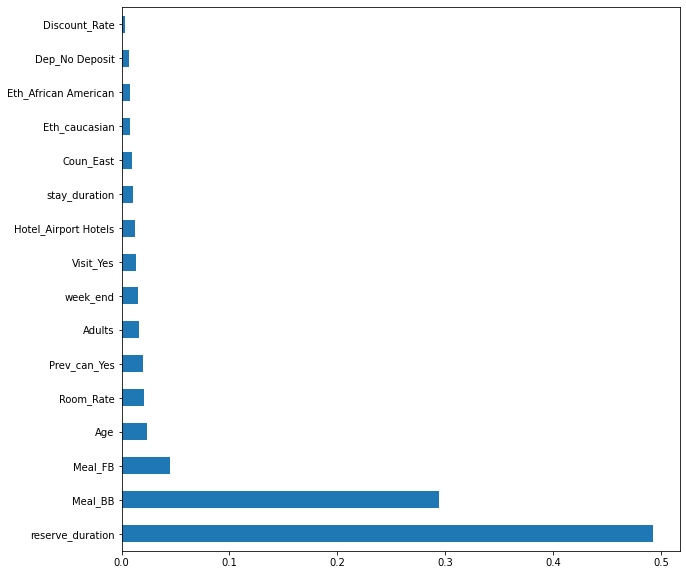

Age                     0.023266
Adults                  0.016466
Discount_Rate           0.003448
Room_Rate               0.020524
week_end                0.015594
stay_duration           0.010430
reserve_duration        0.492706
Eth_African American    0.007610
Eth_caucasian           0.007635
Coun_East               0.010118
Hotel_Airport Hotels    0.012576
Meal_BB                 0.294616
Meal_FB                 0.044751
Visit_Yes               0.013588
Prev_can_Yes            0.019955
Dep_No Deposit          0.006717
dtype: float64


In [42]:
#Feature Importance in Decision Tree Classifier
print("Feature Importance")
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.figure(figsize=[10,10])
feat_importances = pd.Series(model.feature_importances_, index=train_data.columns)
feat_importances.nlargest(40).plot(kind='barh')

plt.show()
print(feat_importances)

In [45]:
['Age','Adults','Discount_Rate','Room_Rate','week_end','stay_duration','reserve_duration','Eth_African American','Eth_caucasian','Coun_East','Hotel_Airport Hotels','Meal_BB','Meal_FB','Visit_Yes','Prev_can_Yes','Dep_No Deposit']

['Age',
 'Adults',
 'Discount_Rate',
 'Room_Rate',
 'week_end',
 'stay_duration',
 'reserve_duration',
 'Eth_African American',
 'Eth_caucasian',
 'Coun_East',
 'Hotel_Airport Hotels',
 'Meal_BB',
 'Meal_FB',
 'Visit_Yes',
 'Prev_can_Yes',
 'Dep_No Deposit']

##XGB Boost Approach

In [46]:
clf = DecisionTreeClassifier(max_depth=50, class_weight = 'balanced')
model=xgboost.XGBClassifier(base_estimator=clf,max_depth=20,n_estimators=15,objective='multi:softmax',gamma=4.63,learning_rate=0.2,reg_lambda=1).fit(train_data,train_label)
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.970770869173425
Validation accuracy : 0.4721716987995635
Precision : 0.35822553260591405
Recall : 0.3544022237742556
F1-Score : 0.3547096787336328
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      1610
           1       0.28      0.28      0.28       741
           2       0.19      0.14      0.16       398

    accuracy                           0.47      2749
   macro avg       0.36      0.35      0.35      2749
weighted avg       0.46      0.47      0.46      2749

Confusion Matrix
[[1033  418  159]
 [ 456  210   75]
 [ 231  112   55]]


##Support Vector Machine Approach

In [ ]:

model = svm.SVC(degree=9,decision_function_shape='ovo', class_weight = 'balanced')
model.fit(train_data,train_label)       
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

##MLP classifier approach

In [47]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='adam',learning_rate = 'adaptive',learning_rate_init=0.01,activation= 'relu', alpha=1e-6, hidden_layer_sizes=(150, ), random_state=91,max_iter=400)
model.fit(train_data,train_label) 
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.41458179732940115
Validation accuracy : 0.38523099308839576
Precision : 0.34352386792782275
Recall : 0.3419062451398042
F1-Score : 0.3252878536007796
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.48      0.53      1610
           1       0.28      0.21      0.24       741
           2       0.15      0.34      0.20       398

    accuracy                           0.39      2749
   macro avg       0.34      0.34      0.33      2749
weighted avg       0.45      0.39      0.41      2749

Confusion Matrix
[[771 298 541]
 [337 152 252]
 [178  84 136]]


##Random Forest approach

In [48]:
model = RandomForestClassifier(max_depth=7,max_features=10,n_estimators=75, class_weight = 'balanced' )
model.fit(train_data,train_label)       
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.5107069714098468
Validation accuracy : 0.34085121862495454
Precision : 0.35179415102872064
Recall : 0.34885444734001014
F1-Score : 0.31800211728952177
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.31      0.41      1610
           1       0.29      0.43      0.35       741
           2       0.15      0.31      0.20       398

    accuracy                           0.34      2749
   macro avg       0.35      0.35      0.32      2749
weighted avg       0.46      0.34      0.36      2749

Confusion Matrix
[[494 623 493]
 [194 321 226]
 [106 170 122]]


##KNN approach

In [49]:
model=KNeighborsClassifier(n_neighbors=3,algorithm='auto',weights='distance')
model.fit(train_data,train_label)       
y_predict=model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 1.0
Validation accuracy : 0.42779192433612223
Precision : 0.3273920266375233
Recall : 0.3274397682525277
F1-Score : 0.3274104464273428
Classification Report
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1610
           1       0.26      0.26      0.26       741
           2       0.15      0.15      0.15       398

    accuracy                           0.43      2749
   macro avg       0.33      0.33      0.33      2749
weighted avg       0.43      0.43      0.43      2749

Confusion Matrix
[[926 440 244]
 [452 190  99]
 [236 102  60]]


##Ensemble - extra tree classifier approach

In [50]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(max_depth=6,n_estimators=100, class_weight = 'balanced')
model.fit(train_data, train_label)
y_predict= model.predict(val_data)
print("Train accuracy : "+str(model.score(train_data,train_label)))
print("Validation accuracy : "+str(model.score(val_data,val_label)))
print("Precision : "+str(precision_score(val_label,y_predict,average='macro', zero_division=0)))
print("Recall : "+str(recall_score(val_label,y_predict,average='macro', zero_division=0)))
print("F1-Score : "+str(f1_score(val_label,y_predict,average='macro', zero_division=0)))
print("Classification Report")
print(classification_report(val_label,y_predict,zero_division=0))
print("Confusion Matrix")
print(confusion_matrix(val_label,y_predict))
#fig, ax = plt.subplots()
#plot_confusion_matrix(val_label, y_predict, ax=ax)


neptune.log_metric('Training Accuracy', model.score(train_data,train_label))
neptune.log_metric('Validation Accuracy', model.score(val_data,val_label))
neptune.log_metric('Precision',precision_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('Recall', recall_score(val_label,y_predict,average='macro', zero_division=0))
neptune.log_metric('F1-Score',f1_score(val_label,y_predict,average='macro', zero_division=0))

Train accuracy : 0.4656836241500778
Validation accuracy : 0.35685703892324483
Precision : 0.35497140562764806
Recall : 0.35499149098495947
F1-Score : 0.3295084221965394
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.35      0.45      1610
           1       0.29      0.37      0.33       741
           2       0.15      0.34      0.21       398

    accuracy                           0.36      2749
   macro avg       0.35      0.35      0.33      2749
weighted avg       0.46      0.36      0.38      2749

Confusion Matrix
[[571 521 518]
 [226 275 240]
 [125 138 135]]


##Neptune log order of Models

In [51]:
model_list=['logistic regression','Decision Tree Classifier', 'XGB Boost','MLP classifier', 'Random Forest', 'KNN', 'Ensemble - extra tree classifier'  ]
for i in model_list:
  neptune.log_text('Model order',i)
  

In [52]:
neptune.stop()

#Prediction For submission

In [30]:
y_predict_2= model.predict(test_data)
y_predict_2


array([0, 0, 2, ..., 0, 0, 1])

In [31]:
y_predict_2=le.inverse_transform(y_predict_2)
y_predict_2

array([1, 1, 3, ..., 1, 1, 2], dtype=object)

In [32]:
y_predict_2=pd.DataFrame(y_predict_2,columns=['Reservation_status'] )
y_predict_2

,Reservation_status
0,1
1,1
2,3
3,1
4,1
...,...
4313,2
4314,1
4315,1
4316,1


In [33]:
test_reservation=pd.DataFrame(test_reservation)
test_reservation

,Reservation-id
0,62931593
1,70586099
2,4230648
3,25192322
4,80931528
...,...
4313,39110574
4314,5496554
4315,59004046
4316,65838682


In [34]:
test_reservation=pd.concat([test_reservation,y_predict_2],axis=1)
test_reservation

,Reservation-id,Reservation_status
0,62931593,1
1,70586099,1
2,4230648,3
3,25192322,1
4,80931528,1
...,...,...
4313,39110574,2
4314,5496554,1
4315,59004046,1
4316,65838682,1


In [35]:
test_reservation.to_csv('submission_XGBoost_upsampled_0.33_0.33_0.33_selected_feature_16.csv',index=False)